# Import Libary

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mplsoccer import VerticalPitch, Pitch, create_transparent_cmap, FontManager, arrowhead_marker
from matplotlib.patches import Rectangle, Circle, Polygon
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib import image, font_manager
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

# Load Data

In [10]:
match_date = 'Kamis, 23 Mei 2024'
competition = 'UEFA European League'
season = '2023-2024'

In [11]:
events_data_url = "Events_Data_Atalanta_VS_Leverkusen_Europa League_2024-05-22"
match_data_url = "Match_Data_Atalanta_VS_Leverkusen_Europa League_2024-05-22"

In [12]:
with open(f'example_data\\{events_data_url}.json') as data_file:
    events_data = json.load(data_file)
events_data = pd.read_json(events_data)

C:\Users\hamry\AppData\Local\Temp\ipykernel_12316\1711618321.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  events_data = pd.read_json(events_data)


In [13]:
with open (f'example_data\\{match_data_url}.json', 'rb') as fp:
    match_data = json.load(fp)

In [14]:
jerseyNumber = pd.DataFrame({'jerseyNumber': match_data['home']['formations'][0]['jerseyNumbers'] + match_data['away']['formations'][0]['jerseyNumbers'],
                             'playerId': match_data['home']['formations'][0]['playerIds'] + match_data['away']['formations'][0]['playerIds']})
playerIdNameDictionary = match_data['playerIdNameDictionary']
playerdict_df = pd.Series(playerIdNameDictionary).to_frame('playerName')
playerdict_df.index.name = 'playerId'
playerdict_df.index = playerdict_df.index.astype('int64')
jerseyNumber['playerId'] = jerseyNumber['playerId'].astype(object)
jerseyNumber = jerseyNumber.set_index('playerId')
kit_no = pd.merge(jerseyNumber, playerdict_df, on='playerId')

events_data = pd.merge(left=events_data, right=jerseyNumber, on='playerId', how='left')

In [15]:
Home_Team = match_data['home']['name']
Away_Team = match_data['away']['name']
Home_Team_ID = match_data['home']['teamId']
Away_Team_ID = match_data['away']['teamId']
Home_Score = int(match_data['score'].split()[0])
Away_Score = int(match_data['score'].split()[2])
Date = match_data['timeStamp'].split(' ')[0].split('-')[2] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[1] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[0]
Competition = match_data['league']
Season = match_data['season']

# Passing Network

In [16]:
def passing_network(events_data, ax, venue, match_data, TeamId, Team, pitch_line_color, marker_color, pass_color, edge_marker_color):
    starters_player_ids = []
    for i in range(11):
        starters_player_ids.append(match_data[venue]['formations'][0]['playerIds'][i])
    playerIdNameDictionary = match_data['playerIdNameDictionary']
    starters = {}
    for player_id in starters_player_ids:
        starters[player_id] = playerIdNameDictionary[str(player_id)]
    starters_player_name = []
    for key in starters.keys():
        starters_player_name.append(starters[key])
    
    # Make df with Successfull Passes until the First Substitution
    mask = (events_data.type == 'Pass') & (events_data.teamId == TeamId) & (events_data.outcomeType == 'Successful') & (events_data.throwIn != True)
    team_event = events_data[events_data['teamId'] == TeamId]
    team_event.insert(26, 'passRecipientName', value=team_event['playerName'].shift(-1))
    team_event.insert(27, 'passRecipientId', value=team_event['playerId'].shift(-1))
    team_passes = team_event.loc[mask, ['x', 'y', 'endX', 'endY', 'playerName', 'jerseyNumber', 'passRecipientName']]
    team_passes = team_passes.query(f"playerName == {starters_player_name} & passRecipientName == {starters_player_name}")
    
    scatter_df = pd.DataFrame()

    for i, name in enumerate(team_passes["playerName"].unique()):
        passx = team_passes.loc[team_passes["playerName"] == name]["x"].to_numpy()  
        recx = team_passes.loc[team_passes["passRecipientName"] == name]["endX"].to_numpy()
        passy = team_passes.loc[team_passes["playerName"] == name]["y"].to_numpy()
        recy = team_passes.loc[team_passes["passRecipientName"] == name]["endY"].to_numpy()
        
        scatter_df.at[i, "player_name"] = name
        scatter_df.at[i, "jerseyNumber"] = events_data[events_data['playerName'] == name].iloc[0]['jerseyNumber']
        
        # Make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        
        # Calculate the Number of Passes
        scatter_df.at[i, "number_of_passes"] = team_passes.loc[team_passes["playerName"] == name].count().iloc[0]

    # Adjust the size of Circle by Number of Passes
    scatter_df['marker_size'] = (scatter_df['number_of_passes'] / scatter_df['number_of_passes'].max() * 500 + 200)

    # Counting passes between players
    team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
    lines_df = team_passes.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    
    # Setting a Treshold of Number Passes
    min_pass_count = 2
    lines_df = lines_df[lines_df['pass_count'] > min_pass_count]


    color = 'white'

    pitch = VerticalPitch(line_color=pitch_line_color, pitch_type='opta', corner_arcs=True, goal_type='line',
                        pad_bottom=0, pad_top=0, pad_left=0, pad_right=0, pitch_color='None')
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=marker_color, edgecolors=edge_marker_color, linewidth=2, alpha=1, ax=ax, zorder = 3)

    for i, row in scatter_df.iterrows():
        pitch.annotate(int(row.jerseyNumber), xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=10, ax=ax, zorder = 4)

    for i, row in lines_df.iterrows():
            link = row['pass_count']
            alpha = link / 20
            if alpha > 1:
                alpha = 1
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]

            # Take the Average Location of Players to Plot Line between Them 
            player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
            player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
            player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
            player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
            num_passes = row["pass_count"]

            # Adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 8)

            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color=pass_color, ax = ax)

# Shotmap

In [17]:
def shotmap(df, ax, pitch_line_color):
    df = df[(df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')].reset_index(drop=True)
    pitch = Pitch(pitch_type = 'opta', half = False, goal_type = 'line', goal_alpha = 1, line_color = pitch_line_color, linewidth = 1, corner_arcs=True, pitch_color='None')
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    for i in range(len(df)):
        if df.h_a[i] == 'h':
            ec = 'blue'
            cm = 'red'
        else:
            ec = 'red'
            cm = 'blue'
        pitch.scatter(
            # Coordinates
            (100 - df.x[i]) if (df.h_a[i] == 'h') else df.x[i],
            (100 - df.y[i]) if (df.h_a[i] == 'h') else df.y[i],
            # Size Between 100 and 300
            s = 100,
            # Type of Marker
            marker = 'o',
            # Color Marker
            c = cm if (df.type[i] == 'Goal' or df.type[i] == 'OwnGoal') else 'white',
            # Color Marker Border
            edgecolors = ec, ax = ax,
            zorder = 1 if (df.type[i] == 'Goal' or df.type[i] == 'OwnGoal') else 0
        )
    
    ax.text(x = 3, y = 3, s = f'{Home_Team.upper()} SHOTS', size = 20, c = '0.5', ha='left')
    ax.text(x = 98, y = 3,s = f'{Away_Team.upper()} SHOTS', size = 20, c = '0.5', ha = 'right')

# Player Statistics

In [19]:
def player_statistic(match_data, events_data, venue, ax, line_color):
    if venue == 'home':
        h_a = 'h'
    else:
        h_a = 'a'

    team_events = events_data[events_data.h_a == h_a]

    player_statistics = {}
    for i in range(len(match_data['away']['players'])):
        stats = {}
        for player_stats in match_data['away']['players'][i]['stats'].keys():
            stats[player_stats] = sum(match_data['away']['players'][i]['stats'][player_stats].values())
        player_id = match_data['away']['players'][i]['playerId']
        player_statistics[player_id] = stats
    
    ratings = {}
    for player in match_data[venue]['players']:
        if 'isFirstEleven' in list(player.keys()):
            ratings[player['playerId']] = player['stats']['ratings'][list(player['stats']['ratings'].keys())[len(player['stats']['ratings'].keys()) - 1]]
        elif 'subbedInExpandedMinute' in list(player.keys()):
            ratings[player['playerId']] = player['stats']['ratings'][list(player['stats']['ratings'].keys())[len(player['stats']['ratings'].keys()) - 1]]
        else:
            pass
    
    jersey_number = {'jerseyNumber': match_data['home']['formations'][0]['jerseyNumbers'] + match_data['away']['formations'][0]['jerseyNumbers'], 
                 'playerId': match_data['home']['formations'][0]['playerIds'] + match_data['away']['formations'][0]['playerIds']}
    kit_numbers = {}
    for i in range(len(jersey_number['jerseyNumber'])):
        kit_numbers[jersey_number['playerId'][i]] = jersey_number['jerseyNumber'][i]
    playerIdNameDictionary = match_data['playerIdNameDictionary']

    players = []
    for id in list(ratings.keys()):
        player = {}
        player['id'] = id
        player['kit_no'] = kit_numbers[id]
        player['name'] = playerIdNameDictionary[str(id)]
        player['rating'] = ratings[id]
        player['kit_no'] = kit_numbers[id]
        player['goals'] = len(events_data[(events_data.playerId == id) & (events_data.isGoal == True)])
        player['assist'] = len(events_data[(events_data.playerId == id) & (events_data.assist == True)])
        player['pass_attempted'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'Pass')])
        player['pass_completed'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'Pass') & (events_data.outcomeType == 'Successful')])
        player['key_pass'] = len(events_data[(events_data.playerId == id) & ((events_data['keyPassLong'] == True) | (events_data['keyPassShort'] == True) | (events_data['keyPassCross'] == True) | (events_data['keyPassCorner'] == True) | (events_data['keyPassThroughball'] == True) | (events_data['keyPassFreekick'] == True) | (events_data['keyPassThrowin'] == True) | (events_data['keyPassOther'] == True))])
        player['shot_attempted'] = len(events_data[(events_data.playerId == id) & ((events_data['type'] == 'Goal') | (events_data['type'] == 'MissedShots') | (events_data['type'] == 'SavedShot') | (events_data['type'] == 'ShotOnPost'))])
        player['shot_on_target'] = len(events_data[(events_data.playerId == id) & ((events_data['type'] == 'Goal') | (events_data['type'] == 'SavedShot') | (events_data['type'] == 'ShotOnPost'))])
        player['big_chance']= len(events_data[(events_data.playerId == id) & ((events_data.bigChanceMissed == True) | (events_data.bigChanceScored == True))])
        player['yellow_card'] = len(events_data[(events_data.playerId == id) & (events_data.yellowCard == True)])
        player['second_yellow'] = len(events_data[(events_data.playerId == id) & (events_data.secondYellow == True)])
        player['red_card'] = len(events_data[(events_data.playerId == id) & (events_data.redCard == True)])
        player['substituon_on'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'SubstitutionOn')])
        player['substituon_off'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'SubstitutionOff')])
        players.append(player)
    
    
    rows = 16
    cols = 12

    # Title
    x = 0.5
    ax.text(x=x, y=rows, s='No.', va='center', ha='center', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Sub', va='center', ha='left', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Card', va='center', ha='left', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Player Name', va='center', ha='left', size=10, weight='bold')
    x += 4.9
    ax.text(x=x, y=rows, s='Pass/Comp/Key', va='center', ha='center', size=10, weight='bold')
    x += 2.3
    ax.text(x=x, y=rows, s='Shot/On/Big', va='center', ha='center', size=10, weight='bold')
    x += 1.7
    ax.text(x=x, y=rows, s='Goal', va='center', ha='center', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Assist', va='center', ha='center', size=10, weight='bold')
    x += 1.2
    ax.text(x=x, y=rows, s='Rating', va='center', ha='center', size=10, weight='bold')

    for row in range(rows):
        try:
            col_num = 0
            player = players[row]

            # Kit No
            x = 0.5
            ax.text(x=x, y=rows - row - 1, s=player['kit_no'], va='center', ha='center', size=10)

            # Subs
            def subs_on(x, y):
                sub_on = patches.FancyArrowPatch((x-0.3, y), (x+0.3, y), lw=3, color='blue', alpha=1, mutation_scale=10)
                ax.add_patch(sub_on)
            
            def subs_off(x, y):
                sub_on = patches.FancyArrowPatch((x+0.3, y), (x-0.3, y), lw=2, color='red', alpha=1, mutation_scale=10)
                ax.add_patch(sub_on)

            x += 1
            if player['substituon_on'] > 0:
                subs_on(x=x+0.2, y=rows - row - 1)
            elif player['substituon_off'] > 0:
                subs_off(x=x+0.2, y=rows - row - 1)
            else:
                pass

            # Card
            def yellow_card(x, y):
                yellow_card = patches.Rectangle((x, y - 0.3), width=.5, height=.6, lw=1, ec='black', fc='yellow', alpha=1, zorder=-1)
                ax.add_patch(yellow_card)

            def red_card(x, y):
                yellow_card = patches.Rectangle((x, y - 0.3), width=.5, height=.6, lw=1, ec='black', fc='red', alpha=1, zorder=-1)
                ax.add_patch(yellow_card)

            def second_yellow(x, y):
                yellow_card(x=x-0.1, y=y-0.1)
                yellow_card(x=x+0.1, y=y+0.1)

            x += 1
            if player['second_yellow'] > 0:
                second_yellow(x=x, y=rows - row - 1)
            elif player['red_card'] > 0:
                red_card(x=x, y=rows - row - 1)
            elif player['yellow_card'] > 0:
                yellow_card(x=x, y=rows - row - 1)
            else:
                pass

            # Player Name
            x += 1
            ax.text(x=x, y=rows - row - 1, s=player['name'], va='center', ha='left', size=10)

            # Passes
            x += 4.9
            ax.text(x=x, y=rows - row - 1, s=f"{player['pass_attempted']}/{player['pass_completed']}({int(player['pass_completed'] / player['pass_attempted'] * 100)}%)/{player['key_pass']}", va='center', ha='center', size=10)
            
            # Shot
            x += 2.3
            ax.text(x=x, y=rows - row - 1, s=f"{player['shot_attempted']}/{player['shot_on_target']}/{player['big_chance']}", va='center', ha='center', size=10)

            # Goal
            x += 1.7
            ax.text(x=x, y=rows - row - 1, s=player['goals'], va='center', ha='center', size=10)

            # Assist
            x += 1
            ax.text(x=x, y=rows - row - 1, s=player['assist'], va='center', ha='center', size=10)

            # Rating
            x += 1.2
            ax.text(x=x, y=rows - row - 1, s=round(player['rating'], 1), va='center', ha='center')

            ax.plot([0, x+1], [rows - row -.5, rows - row - .5], ls=':', lw='1', c=line_color)
            last = row
        except:
            pass

    ax.plot([0, x+1], [rows - last - 1 -.5, rows - last - 1 - .5], ls='-', lw='1', c=line_color)
    ax.plot([0, x+1], [rows - 0.5, rows - 0.5], lw='1', c=line_color)

    # set up the axis limits with "spacing" (a bit of padding on each side)
    ax.set_ylim(-1, 16 + 1.5)
    ax.set_xlim(0, x + 1)

    # rect = patches.Rectangle((1.65, -.5), .65, height=1, lw=1, ec='none', fc='grey', alpha=.2, zorder=-1)
    # ax.add_patch(rect)
    ax.axis('off')

# Match Statistics

In [20]:
def scatter_football(x, y, ax=None, **kwargs):
    import matplotlib.path as mpath

    # football hexagon arrays
    football_hexagon_codes = np.array([1, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 79, 1, 3,
                                    3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 3,
                                    3, 4, 4, 4, 3, 3, 2, 3, 3, 79, 1, 2, 3, 3, 4, 4, 4,
                                    3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 3, 3, 4, 4, 4, 3, 3,
                                    3, 3, 3, 3, 79, 1, 1, 1, 1])
    football_hexagon_vertices = np.array([[-0.22499999999999998, -0.3096859321060139],
                                        [-0.3578624191511828, -0.42126390612162967],
                                        [-0.4307248383023656, -0.5928418801372455],
                                        [-0.29662436542138726, -0.7538845585184165],
                                        [-0.22252389254040889, -0.9749272368995876],
                                        [-0.07605800448461039, -1.0083575877001376],
                                        [0.07605800448461039, -1.0083575877001376],
                                        [0.22252389254040889, -0.9749272368995876],
                                        [0.29662436542138726, -0.7538845585184165],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.3578624191511828, -0.4212639061216298],
                                        [0.22499999999999987, -0.30968593210601403],
                                        [-0.00000000000000005551115123125783, -0.33968593210601394],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.35786241915118266, -0.42126390612162967],
                                        [0.4307248383023654, -0.5928418801372455],
                                        [0.6745860377099481, -0.5228718813250733],
                                        [0.8584472371175307, -0.5129018825129013],
                                        [0.9355018385938869, -0.38393509178776364],
                                        [0.982508270481868, -0.2392641702247741],
                                        [0.9959745660164324, -0.0896362864490644],
                                        [0.8164509970942311, 0.038404580904486146],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.5004925378203781, 0.1423674742424208],
                                        [0.36405764746872626, 0.11828950022680491],
                                        [0.3245288237343631, -0.06569821593960454],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.5004925378203782, 0.14236747424242066],
                                        [0.69692742817203, 0.22644544825803642],
                                        [0.6950004453997567, 0.47219094443542353],
                                        [0.7530734626274834, 0.6579364406128105],
                                        [0.654229937273651, 0.77107265150149],
                                        [0.531165500901059, 0.8604841982111864],
                                        [0.3930222411881726, 0.919528965248744],
                                        [0.22651112059408626, 0.7961609145035808],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [0.00000000000000013877787807814457, 0.3827928637584179],
                                        [0.2120288237343632, 0.28054118199261147],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [0.00000000000000016653345369377348, 0.7327928637584178],
                                        [-0.226511120594086, 0.796160914503581],
                                        [-0.3930222411881722, 0.9195289652487442],
                                        [-0.5311655009010592, 0.8604841982111865],
                                        [-0.6542299372736504, 0.771072651501486],
                                        [-0.7530734626274826, 0.6579364406128061],
                                        [-0.6950004453997563, 0.41219094443542137],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.5604925378203782, 0.14236747424242088],
                                        [-0.36405764746872626, 0.1182895002268052],
                                        [-0.21202882373436308, 0.28054118199261147],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-0.560492537820378, 0.142367474242421],
                                        [-0.6969274281720299, 0.2264454482580368],
                                        [-0.8164509970942311, 0.03840458090448631],
                                        [-0.9959745660164324, -0.08963628644906418],
                                        [-0.9825082704818681, -0.23926417022477386],
                                        [-0.9355018385938869, -0.38393509178776364],
                                        [-0.8584472371175307, -0.5129018825129013],
                                        [-0.6145860377099481, -0.5228718813250733],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.3578624191511829, -0.42126390612162967],
                                        [-0.2250000000000001, -0.30968593210601386],
                                        [-0.3245288237343631, -0.12569821593960442],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-1.0204451903760434, -1.0083575877001376],
                                        [-1.0204451903760434, 1.0268236782504188],
                                        [1.0204451903760436, -1.0083575877001376],
                                        [1.0204451903760436, 1.0268236782504188]])

    # football pentagon arrays
    football_pentagon_codes = np.array([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 4, 4,
                                        4, 3, 3, 79, 1, 3, 3, 4, 4, 4, 3, 3, 79, 1, 3, 3, 4,
                                        4, 4, 3, 3, 79, 1, 3, 3, 4, 4, 4, 3, 3, 79, 1, 3, 3,
                                        4, 4, 4, 3, 3, 79, 1, 1, 1, 1])
    football_pentagon_vertices = np.array([[0.000000000000000023439302766909766, 0.38279286375841787],
                                        [-0.21202882373436308, 0.28054118199261147],
                                        [-0.3640576474687262, 0.11828950022680507],
                                        [-0.3245288237343631, -0.12569821593960442],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [-0.00000000000000005551115123125783, -0.33968593210601394],
                                        [0.22499999999999987, -0.30968593210601403],
                                        [0.3245288237343631, -0.06569821593960454],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.2120288237343632, 0.28054118199261147],
                                        [0.00000000000000011719651383454883, 0.38279286375841787],
                                        [0.00000000000000011719651383454883, 0.38279286375841787],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.29662436542138726, -0.7538845585184165],
                                        [0.22252389254040889, -0.9749272368995876],
                                        [0.48867813807221294, -0.9141784174079514],
                                        [0.7184254914884021, -0.7472571944544121],
                                        [0.8584472371175307, -0.5129018825129013],
                                        [0.6745860377099481, -0.5228718813250733],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.8164509970942311, 0.038404580904486146],
                                        [0.9959745660164324, -0.0896362864490644],
                                        [1.0204451903760436, 0.18226386071471035],
                                        [0.9326895101963948, 0.4523480728972359],
                                        [0.7530734626274834, 0.6579364406128105],
                                        [0.6950004453997567, 0.47219094443542353],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [0.22651112059408626, 0.7961609145035808],
                                        [0.3930222411881726, 0.919528965248744],
                                        [0.1419916732365391, 1.0268236782504185],
                                        [-0.14199167323653866, 1.0268236782504188],
                                        [-0.3930222411881722, 0.9195289652487442],
                                        [-0.226511120594086, 0.796160914503581],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.6950004453997563, 0.41219094443542137],
                                        [-0.7530734626274826, 0.6579364406128061],
                                        [-0.9326895101963917, 0.452348072897233],
                                        [-1.0204451903760434, 0.18226386071470885],
                                        [-0.9959745660164324, -0.08963628644906418],
                                        [-0.8164509970942311, 0.03840458090448631],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.6145860377099481, -0.5228718813250733],
                                        [-0.8584472371175307, -0.5129018825129013],
                                        [-0.7184254914884021, -0.7472571944544121],
                                        [-0.48867813807221294, -0.9141784174079514],
                                        [-0.22252389254040889, -0.9749272368995876],
                                        [-0.29662436542138726, -0.7538845585184165],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-1.0204451903760434, -1.0083575877001376],
                                        [-1.0204451903760434, 1.0268236782504188],
                                        [1.0204451903760436, -1.0083575877001376],
                                        [1.0204451903760436, 1.0268236782504188]])

    football_hexagon_marker = mpath.Path(football_hexagon_vertices, football_hexagon_codes)
    football_pentagon_marker = mpath.Path(football_pentagon_vertices, football_pentagon_codes)

    linewidths = kwargs.pop('linewidths', 0.5)
    hexcolor = kwargs.pop('c', 'white')
    pentcolor = kwargs.pop('edgecolors', 'black')
    s = kwargs.pop('s', 500)
    sc_hex = ax.scatter(x, y, edgecolors=pentcolor, c=hexcolor, linewidths=linewidths,
                        marker=football_hexagon_marker, s=s, **kwargs)

    if 'label' in kwargs:
        Legend.update_default_handler_map({sc_hex: HandlerFootball()})
        del kwargs['label']

    sc_pent = ax.scatter(x, y, edgecolors=pentcolor, c=pentcolor, linewidths=linewidths,
                         marker=football_pentagon_marker, s=s, **kwargs)

    return sc_hex, sc_pent

In [23]:
def match_statistic(match_data, events_data, ax, line_color):
    Home_Team = match_data['home']['name']
    Away_Team = match_data['away']['name']
    Home_Score = int(match_data['score'].split()[0])
    Away_Score = int(match_data['score'].split()[2])
    Date = match_data['timeStamp'].split(' ')[0].split('-')[2] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[1] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[0]
    Competition = match_data['league']
    Season = match_data['season']

    venue = 'home'
    home_stats = {}
    for key in match_data[venue]['stats'].keys():
        try:
            home_stats[key] = sum(match_data[venue]['stats'][key].values())
        except:
            pass
    home_stats['yellow_card'] = len(events_data[(events_data.h_a == 'h') & (events_data.yellowCard == True)])
    home_stats['red_card'] = len(events_data[(events_data.h_a == 'h') & (events_data.redCard == True)])
    home_stats['offside'] = len(events_data[(events_data.h_a == 'h') & (events_data.offsideGiven == True)])
    home_stats['passes'] = len(events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass')])
    home_stats['passes_completed'] = len(events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass') & (events_data.outcomeType == 'Successful')])
    opponent_passes_three_fifths = events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass') & (events_data.x > 2/5*100)]
    defensive_action_three_fifths = events_data[(events_data.h_a == 'h') & (events_data.x > 2/5*100) & ((events_data.type == 'Tackle') | (events_data.type == 'Foul') | (events_data.type == 'Challenge') | (events_data.type == 'Interception'))].reset_index(drop=True)
    home_stats['ppda'] = len(opponent_passes_three_fifths) / len(defensive_action_three_fifths)
    home_stats['touches'] = len(events_data[(events_data.h_a == 'h') & (events_data.isTouch == True)])
    home_stats['touches_final_third'] = len(events_data[(events_data.h_a == 'h') & (events_data.isTouch == True) & (events_data.x >= 2/3*100)])
    home_stats['touches_opponent_box'] = len(events_data[(events_data.h_a == 'h') & (events_data.isTouch == True) & (events_data.x >= 84) & (events_data.y >= 19) & (events_data.y <= 81)])
    home_stats['passes_final_third'] = len(events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass') & (events_data.x >= 2/3*100)])
    home_stats['passes_opponent_box'] = len(events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass') & (events_data.x >= 84) & (events_data.y >= 19) & (events_data.y <= 81)])


    home_incidents = []
    for key in match_data[venue]['incidentEvents']:
        if 'playerId' in list(key.keys()):
            incident = {}
            incident['name'] = key['type']['displayName']
            incident['minute'] = key['minute'] + key['second']/60
            incident['player_id'] = key['playerId']
            if key['type']['displayName'] == 'Card':
                incident['card_type'] = key['cardType']['displayName']
            home_incidents.append(incident)
    
    venue = 'away'
    away_stats = {}
    for key in match_data[venue]['stats'].keys():
        try:
            away_stats[key] = sum(match_data[venue]['stats'][key].values())
        except:
            pass
    away_stats['yellow_card'] = len(events_data[(events_data.h_a == 'a') & (events_data.yellowCard == True)])
    away_stats['red_card'] = len(events_data[(events_data.h_a == 'a') & (events_data.redCard == True)])
    away_stats['offside'] = len(events_data[(events_data.h_a == 'a') & (events_data.offsideGiven == True)])
    away_stats['passes'] = len(events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass')])
    away_stats['passes_completed'] = len(events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass') & (events_data.outcomeType == 'Successful')])
    opponent_passes_three_fifths = events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass') & (events_data.x > 2/5*100)]
    defensive_action_three_fifths = events_data[(events_data.h_a == 'a') & (events_data.x > 2/5*100) & ((events_data.type == 'Tackle') | (events_data.type == 'Foul') | (events_data.type == 'Challenge') | (events_data.type == 'Interception'))].reset_index(drop=True)
    away_stats['ppda'] = len(opponent_passes_three_fifths) / len(defensive_action_three_fifths)
    away_stats['touches'] = len(events_data[(events_data.h_a == 'a') & (events_data.isTouch == True)])
    away_stats['touches_final_third'] = len(events_data[(events_data.h_a == 'a') & (events_data.isTouch == True) & (events_data.x >= 2/3*100)])
    away_stats['touches_opponent_box'] = len(events_data[(events_data.h_a == 'a') & (events_data.isTouch == True) & (events_data.x >= 84) & (events_data.y >= 19) & (events_data.y <= 81)])
    away_stats['passes_final_third'] = len(events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass') & (events_data.x >= 2/3*100)])
    away_stats['passes_opponent_box'] = len(events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass') & (events_data.x >= 84) & (events_data.y >= 19) & (events_data.y <= 81)])

    away_incidents = []
    for key in match_data[venue]['incidentEvents']:
        if 'playerId' in list(key.keys()):
            incident = {}
            incident['name'] = key['type']['displayName']
            incident['minute'] = key['minute'] + key['second']/60
            incident['player_id'] = key['playerId']
            if key['type']['displayName'] == 'Card':
                incident['card_type'] = key['cardType']['displayName']
            away_incidents.append(incident)

    rows = 12
    cols = 7

    ax.set_ylim(-1, rows + 9)
    ax.set_xlim(0, cols)
    
    # Detail Match
    ax.text(x=cols/2, y=rows+8., s=f'{Competition} {Season}', ha='center', va='center', size=12)
    ax.text(x=cols/2, y=rows+7.5, s=f'{match_date}', ha='center', va='center', size=12)
    ax.text(x=cols/2, y=rows+6.5, s=f'{Home_Score} - {Away_Score}', ha='center', va='center', size=22)
    ax.text(x=cols/2 - 0.4, y=rows+6.5, s=f'{Home_Team}', ha='right', va='center', size=22)
    ax.text(x=cols/2 + 0.4, y=rows+6.5, s=f'{Away_Team}', ha='left', va='center', size=22)
    
    y = rows + 5
    for i in range(len(home_incidents)):
        if home_incidents[i]['name'] == 'Goal':
            ax.text(x=cols/2 - 0.5, y=y, s=f"{int(round(home_incidents[i]['minute'], 0))}'", ha='right', va='center', size=12)
            ax.text(x=cols/2 - 0.8, y=y, s=f"{playerIdNameDictionary[str(home_incidents[i]['player_id'])]}", ha='right', va='center', size=12)
            y -= 0.7
        # elif home_incidents[i]['name'] == 'Card':
            #if home_incidents[i]['card_type'] == 'Yellow':
             #   ax.text(x=cols/2 - 0.5, y=y, s=f"{playerIdNameDictionary[str(home_incidents[i]['player_id'])]} {int(round(home_incidents[i]['minute'], 0))}'", ha='right', va='center')
            #y -= 0.7
            
    scatter_football(ax=ax, x=cols/2, y=rows+4.7)

    y = rows + 5
    for i in range(len(away_incidents)):
        if away_incidents[i]['name'] == 'Goal':
            ax.text(x=cols/2 + 0.5, y=y, s=f"{int(round(away_incidents[i]['minute'], 0))}'", ha='left', va='center', size=12)
            ax.text(x=cols/2 + 0.8, y=y, s=f"{playerIdNameDictionary[str(away_incidents[i]['player_id'])]}", ha='left', va='center', size=12)
            y -= 0.7
        #elif away_incidents[i]['name'] == 'Card':
         #   if away_incidents[i]['card_type'] == 'Yellow':
          #      ax.text(x=cols/2 - 0.5, y=y, s=f"{playerIdNameDictionary[str(away_incidents[i]['player_id'])]} {int(round(away_incidents[i]['minute'], 0))}'", ha='right', va='center')
           # y -= 0.7

    
    # Title
    ax.text(x=cols/2, y=rows+1, s='STATISTIC', ha='center', va='center', size=14, weight='bold')
    ax.text(x=.7, y=rows+1, s=Home_Team.upper(), ha='left', va='center', size=14, weight='bold')
    ax.text(x=cols-.7, y=rows+1, s=Away_Team.upper(), ha='right', va='center', size=14, weight='bold')

    text_size = 12

    # Shots
    y = rows
    ax.text(x=cols/2, y=y, s='Shots', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['shotsTotal']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['shotsTotal']), va='center', ha='right', size=text_size)
    
    # On Target
    y -= 1
    ax.text(x=cols/2, y=y, s='On Target', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['shotsOnTarget']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['shotsOnTarget']), va='center', ha='right', size=text_size)

    # Possession
    y -= 1
    ax.text(x=cols/2, y=y, s='Possession', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{round(home_stats['possession']/(home_stats['possession'] + away_stats['possession'])*100, 1)}%", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{round(away_stats['possession']/(home_stats['possession'] + away_stats['possession'])*100, 1)}%", va='center', ha='right', size=text_size)

    # Touches
    y -= 1
    ax.text(x=cols/2, y=y, s='Touches', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{home_stats['touches']}", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{away_stats['touches']}", va='center', ha='right', size=text_size)

    # Passes
    y -= 1
    ax.text(x=cols/2, y=y, s='Passes', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['passes']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['passes']), va='center', ha='right', size=text_size)

    # Passes Completed
    y -= 1
    ax.text(x=cols/2, y=y, s='Completed Passes', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{round(home_stats['passes_completed'] / home_stats['passes'] * 100, 1)}%", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{round(away_stats['passes_completed'] / away_stats['passes'] * 100, 1)}%", va='center', ha='right', size=text_size)

    # Touches Final Third
    y -= 1
    ax.text(x=cols/2, y=y, s='Touches in Final Third', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{home_stats['touches_final_third']}", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{away_stats['touches_final_third']}", va='center', ha='right', size=text_size)

    # Passes in Final Third
    y -= 1
    ax.text(x=cols/2, y=y, s='Passes in Final Third', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{home_stats['passes_final_third']}", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{away_stats['passes_final_third']}", va='center', ha='right', size=text_size)

    # Touches Opponent Box
    y -= 1
    ax.text(x=cols/2, y=y, s='Touches in Opposition Box', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{home_stats['touches_opponent_box']}", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{away_stats['touches_opponent_box']}", va='center', ha='right', size=text_size)

    # Passes in Opposition Box
    y -= 1
    ax.text(x=cols/2, y=y, s='Passes in Opposition Box', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f"{home_stats['passes_final_third']}", va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f"{away_stats['passes_final_third']}", va='center', ha='right', size=text_size)
    
    # PPDA
    y -= 1
    ax.text(x=cols/2, y=y, s='PPDA', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=round(home_stats['ppda'], 2), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=round(away_stats['ppda'], 2), va='center', ha='right', size=text_size)

    # Fouls
    y -= 1
    ax.text(x=cols/2, y=y, s='Fouls', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['foulsCommited']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['foulsCommited']), va='center', ha='right', size=text_size)

    # Yellow Card
    #y -= 1
    #ax.text(x=cols/2, y=y, s='Yellow Card', va='center', ha='center', size=text_size)
    #ax.text(x=1, y=y, s=home_stats['yellow_card'], va='center', ha='left', size=text_size)
    #ax.text(x=cols-1, y=y, s=away_stats['yellow_card'], va='center', ha='right', size=text_size)

    # Red Card
    #y -= 1
    #ax.text(x=cols/2, y=y, s='Red Cards', va='center', ha='center', size=text_size)
    #ax.text(x=1, y=y, s=home_stats['red_card'], va='center', ha='left', size=text_size)
    #ax.text(x=cols-1, y=y, s=away_stats['red_card'], va='center', ha='right', size=text_size)

    # Offside
    #y -= 1
    #ax.text(x=cols/2, y=y, s='Offsides', va='center', ha='center', size=text_size)
    #ax.text(x=1, y=y, s=home_stats['offside'], va='center', ha='left', size=text_size)
    #ax.text(x=cols-1, y=y, s=away_stats['offside'], va='center', ha='right', size=text_size)

    # Corner Kick
    y -= 1
    ax.text(x=cols/2, y=y, s='Corner Kicks', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['cornersTotal']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['cornersTotal']), va='center', ha='right', size=text_size)

    for row in range(rows + 1):
        ax.plot([0.8, cols-0.8], [row -.5, row - .5], ls=':', lw='1.2', c=line_color)

    ax.plot([0.8, cols-0.8], [rows + 1 - 0.5, rows + 1 - 0.5], lw='1', c=line_color)

    ax.axis('off')

# Progressive Pass

In [24]:
def progressive_pass(ax, events_data, venue, pitch_line_color, pass_color, marker_color):
    if venue == 'home':
        df = events_data[(events_data.type == 'Pass') & (events_data.h_a == 'h')].reset_index(drop=True)
    elif venue == 'away':
        df = events_data[(events_data.type == 'Pass') & (events_data.h_a == 'a')].reset_index(drop=True)

    df['X'] = df.x
    df['Y'] = df.y
    df['ENDX'] = df.endX
    df['ENDY'] = df.endY
    df['xmetre'] = df.x * 1.05
    df['ymetre'] = df.y * 0.68
    df['endXmetre'] = df.endX * 1.05
    df['endYmetre'] = df.endY * 0.68
    df['beginning'] = np.sqrt(np.square(100 - df.x) + np.square(50 - df.y))
    df['end'] = np.sqrt(np.square(100 - df.endX) + np.square(50 - df.endY))
    df['beginningmetre'] = np.sqrt(np.square(105 - df.xmetre) + np.square(34 - df.ymetre))
    df['endmetre'] = np.sqrt(np.square(105 - df.endXmetre) + np.square(34 - df.endYmetre))
    df['progressive'] = df.beginning - df.end
    df['progressivemetre'] = df.beginningmetre - df.endmetre
    df['check'] = [(df.end[x]) / (df.beginning[x]) for x in range(len(df))]
    df['checkmetre'] = [(df.endmetre[x]) / (df.beginningmetre[x]) for x in range(len(df))]
    df['checkprogressive'] = [(df.end[x]) / (df.beginning[x]) < .75 for x in range(len(df))]
    df['test'] = [((df.beginning[x] - df.end[x]) * (df.beginningmetre[x] - df.endmetre[x])) < 0 for x in range(len(df))]

    own_half = df[(df.x < 50) & (df.endX < 50) & (df.progressivemetre > 30)]
    different_halves = df[(df.x < 50) & (df.endX > 50) & (df.progressivemetre > 15)]
    opponent_half = df[(df.x > 50) & (df.endX > 50) & (df.progressivemetre > 10)]

    df = pd.concat([own_half, different_halves, opponent_half]).reset_index(drop=True)
    df = df[(df.outcomeType == 'Successful') & (df.passCorner == False) & (df.throwIn == False)].reset_index(drop=True)

    pitch = VerticalPitch(line_color=pitch_line_color, pitch_type='opta', line_zorder=2, corner_arcs=True, pad_bottom=0, pad_left=0, pad_right=0, pad_top=0, pitch_color='None')
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    for i in range(len(df)):
        
        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
                color=pass_color, lw=4, transparent=True, comet=True,
                alpha_start=0.2, alpha_end=1, ax=ax)
        
        pitch.scatter(df.endX[i], df.endY[i], s=70, marker='o', edgecolors='black',
                    c=marker_color, zorder=2, ax=ax)

# Dashboard

C:\Users\hamry\AppData\Local\Temp\ipykernel_12316\1020235908.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
C:\Users\hamry\AppData\Local\Temp\ipykernel_12316\1020235908.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)


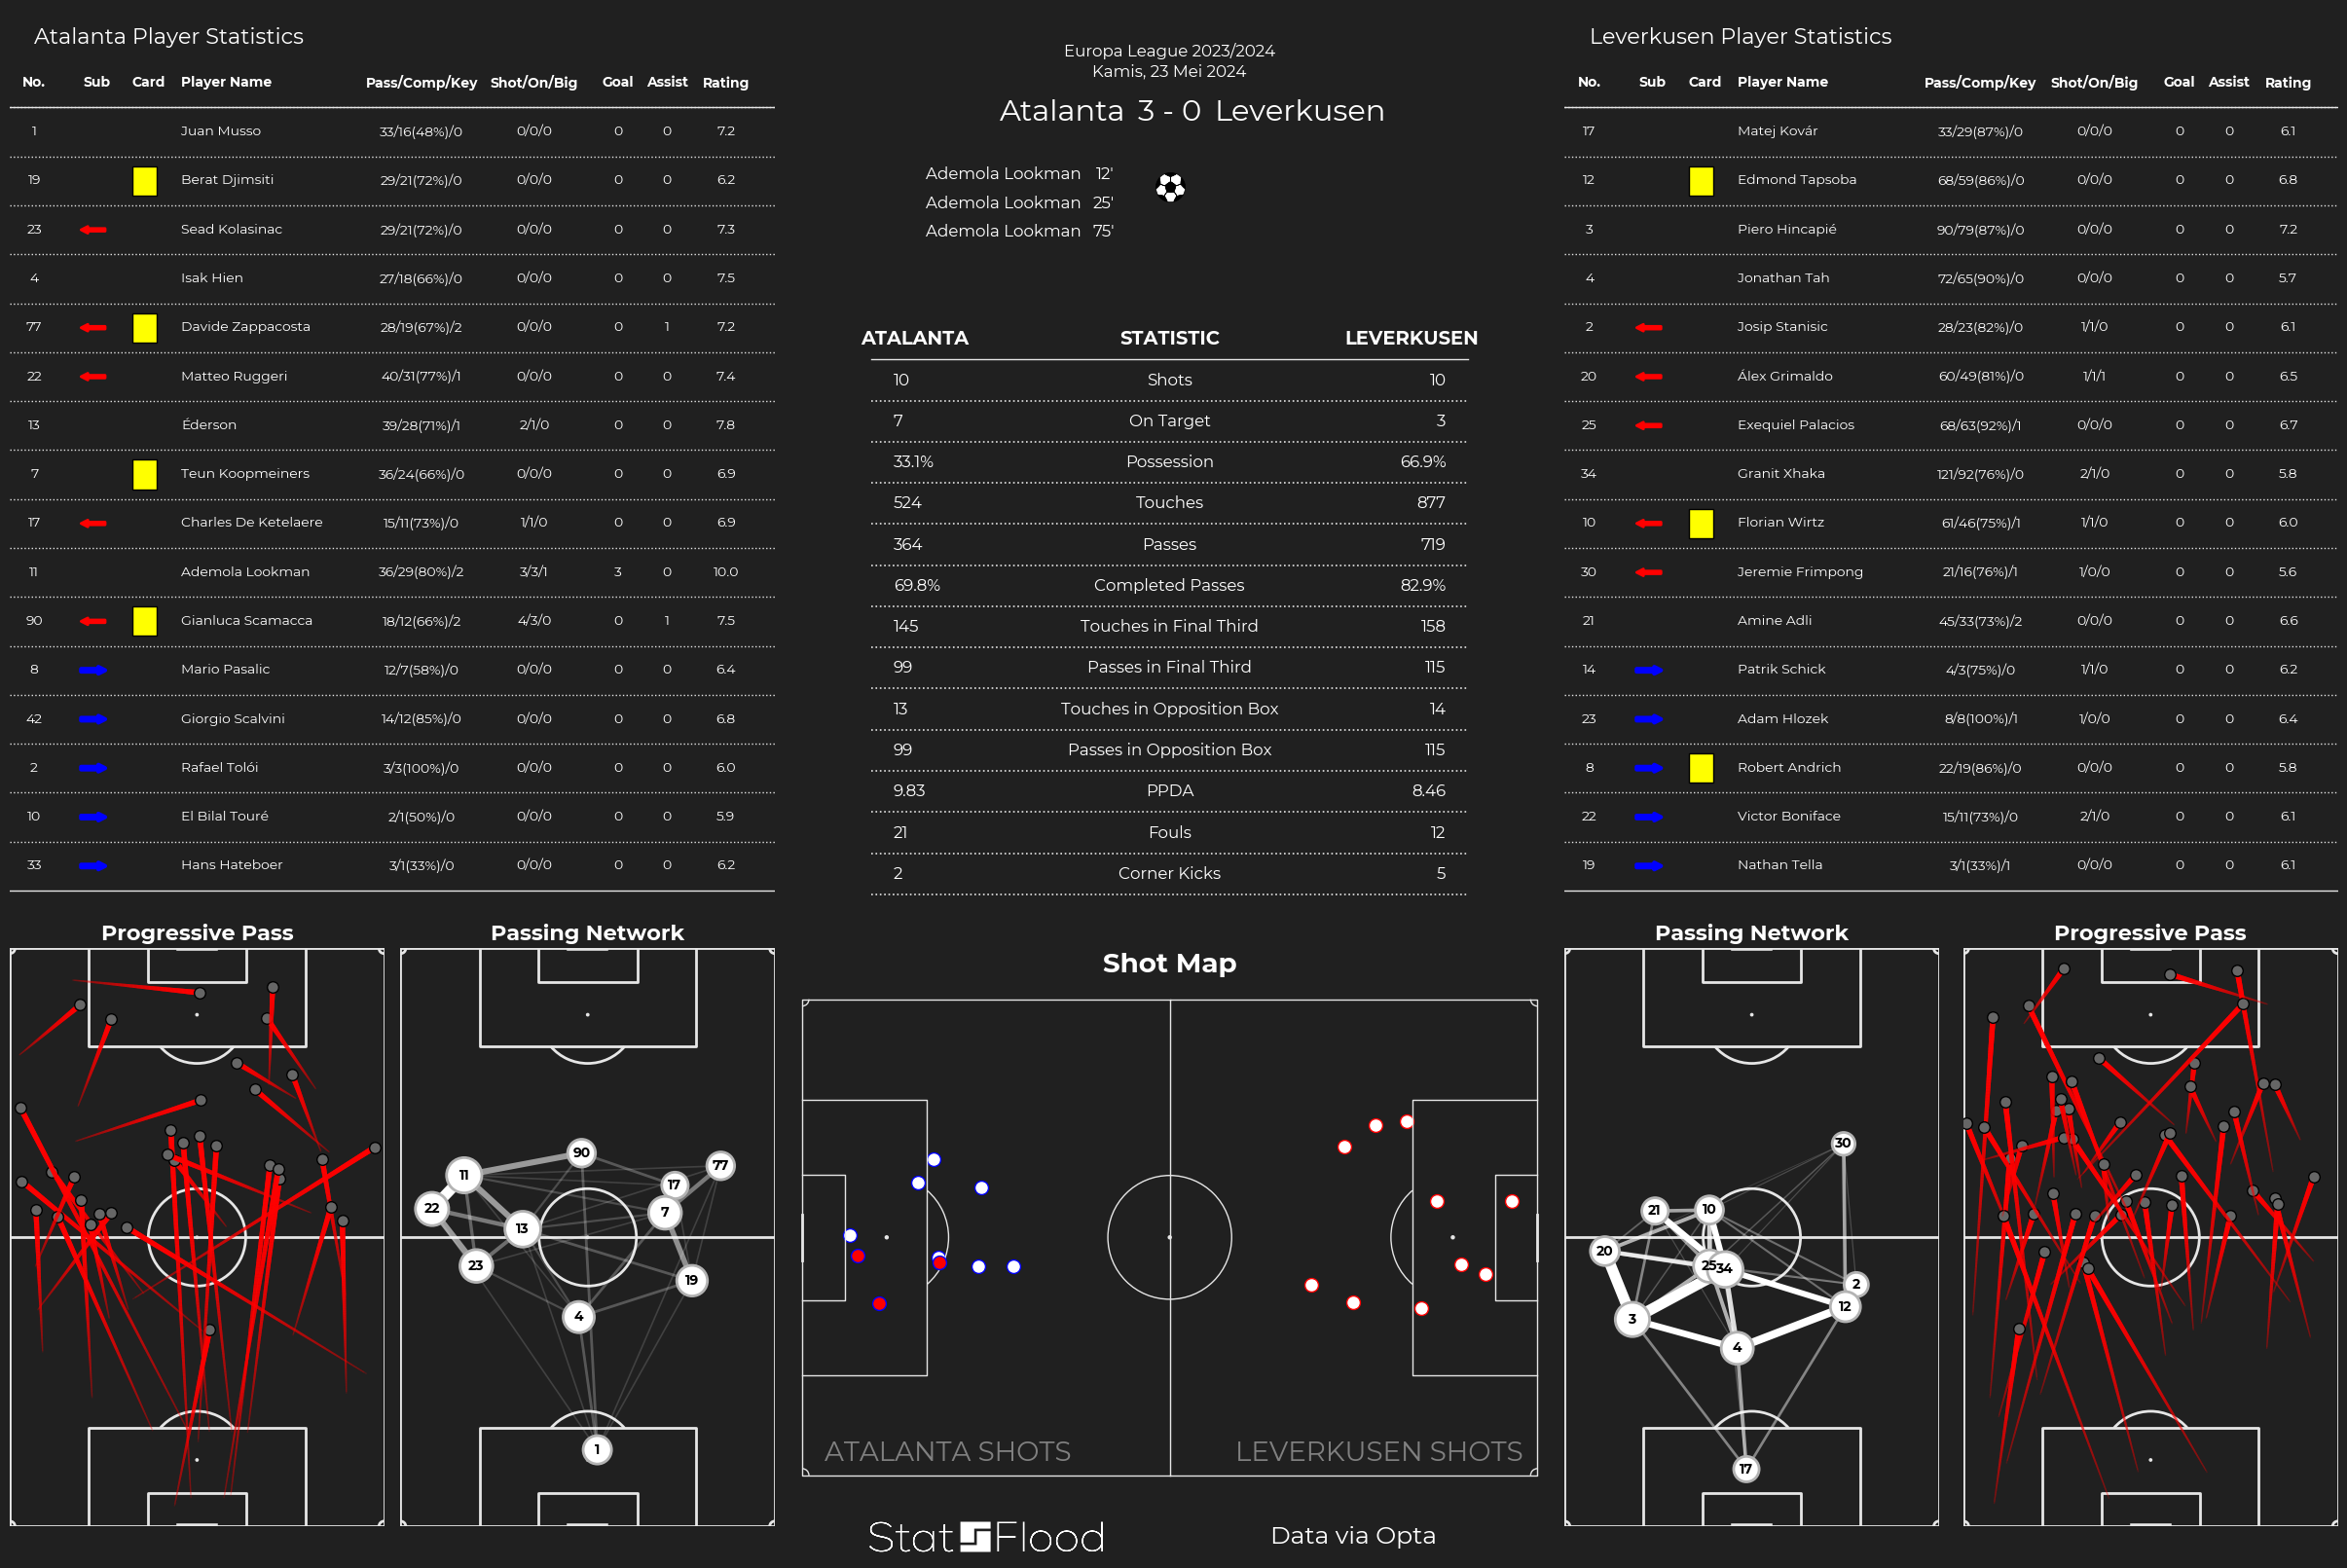

In [26]:
fig = plt.figure(figsize=(24,16), constrained_layout=True)
gs = fig.add_gridspec(nrows=5, ncols=12)

font_dirs = ["D:\Programming\Font"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

fig.set_facecolor('#202020')
line_color = '0.9'
pitch_line_color = '0.9'

plt.rcParams["font.family"] = "Montserrat"
plt.rcParams["text.color"] = "1"
#path_eff = [path_effects.Stroke(linewidth=1, foreground='white'),
#            path_effects.Normal()]
#plt.rcParams["path.effects"] = path_eff
#plt.text(x=0.5, y=0.1, s='Data via Opta and Understat')  

Home_Team = match_data['home']['name']
Away_Team = match_data['away']['name']

ax_match_stats = fig.add_subplot(gs[0:3, 4:8])
match_statistic(match_data=match_data, events_data=events_data, ax=ax_match_stats, line_color=line_color)

ax_player_stats_home = fig.add_subplot(gs[0:3, 0:4])
player_statistic(match_data=match_data, events_data=events_data, venue='home', ax=ax_player_stats_home, line_color=line_color)
ax_player_stats_home.text(x=0.5, y=16.8, s=f"{Home_Team} Player Statistics", size=16, ha='left')

ax_player_stats_away = fig.add_subplot(gs[0:3, 8:12])
player_statistic(match_data=match_data, events_data=events_data, venue='away', ax=ax_player_stats_away, line_color=line_color)
ax_player_stats_away.text(x=0.5, y=16.8, s=f"{Away_Team} Player Statistics", size=16, ha='left')

ax_shotmap = fig.add_subplot(gs[3:6,4:8])
shotmap(df=events_data, ax=ax_shotmap, pitch_line_color=pitch_line_color)
ax_shotmap.text(x=75, y=-13, s='Data via Opta', ha='center', va='center', size=18)
ax_shotmap.set_title('Shot Map', size=20, weight='bold')  

ax_home_passing_network = fig.add_subplot(gs[3:6,2:4])
passing_network(ax=ax_home_passing_network, events_data=events_data, venue='home', match_data=match_data, TeamId=Home_Team_ID, Team=Home_Team,pitch_line_color=pitch_line_color, marker_color='1', pass_color='1', edge_marker_color='0.7')
ax_home_passing_network.set_title('Passing Network', size=16, weight='bold')

ax_away_passing_network = fig.add_subplot(gs[3:6,8:10])
passing_network(ax=ax_away_passing_network, events_data=events_data, venue='away', match_data=match_data, TeamId=Away_Team_ID, Team=Away_Team,pitch_line_color=pitch_line_color, marker_color='1', pass_color='1', edge_marker_color='0.7')
ax_away_passing_network.set_title('Passing Network', size=16, weight='bold')

ax_progressive_pass_home = fig.add_subplot(gs[3:6, 0:2])
progressive_pass(ax=ax_progressive_pass_home, events_data=events_data, venue='home', pass_color='red', pitch_line_color=pitch_line_color, marker_color='0.4')
ax_progressive_pass_home.set_title('Progressive Pass', size=16, weight='bold')

ax_progressive_pass_away = fig.add_subplot(gs[3:6, 10:12])
progressive_pass(ax=ax_progressive_pass_away, events_data=events_data, venue='away', pass_color='red', pitch_line_color=pitch_line_color, marker_color='0.4')
ax_progressive_pass_away.set_title('Progressive Pass', size=16, weight='bold')

logo_path = "StatsFlood.png"
logo = image.imread(logo_path)
imagebox = OffsetImage(logo, zoom=0.18)
ab = AnnotationBbox(imagebox, (2,17), frameon=False)
logo_ax = AnnotationBbox(imagebox, (25,-13), frameon=False, annotation_clip=False)
#ax_player_stats_home.add_artist(ab)
ax_shotmap.add_artist(logo_ax)

plt.show()